In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
# assert len(physical_devices) == 3

# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)
# tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'ds': 'mnist_binary_7x7',
    'distributed': False,
    'minibatch_size': 128,
    'n_steps': 20000,
    'test_size': 300,
    'test_minibatch_size': 300,
    'test_interval': 100,
    'test_n_shuf': [1, 8, 16, 32],
    'test_n_seq': [1, 16, 32, 48],
    'test_autoregressive': False,
    'noise_fraction': 0,
    'display_images': True,
    'display_image_interval': 100,
    'dont_display_until_loss': 0.45,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()


In [5]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'image_size': (28, 28),
    },
    'mnist_8x8': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'rescale': (8, 8),
    },
    'mnist_binary_8x8': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'rescale': (8, 8),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'rescale': (7, 7),
    },
})

config.dataset = ds_configs[config.ds]

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(ds_train_original, num_clusters=config.dataset.n_colors, batch_size=1000)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


Not using gradient accumulation


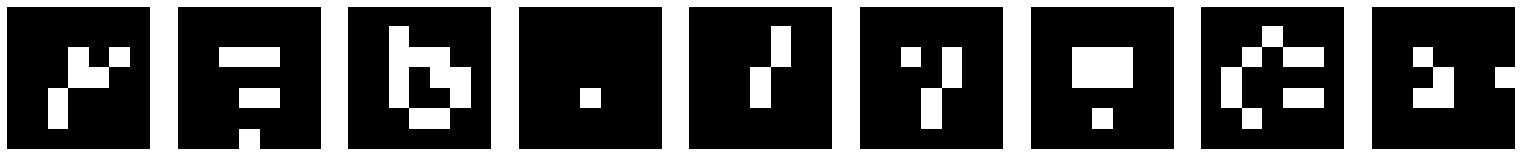

In [6]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.distributed:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [7]:
(train, *_), (test, *_) = ds.make_datasets(for_statistics=True)
print(train.shape, test.shape)

(60000, 49) (10000, 49)


In [8]:
np.count_nonzero(train[:, 30] == 0)

42384

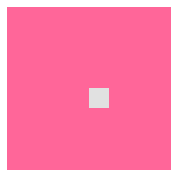

In [9]:
col = tf.expand_dims(tf.constant([1]), 0)
idxs = tf.expand_dims(tf.constant([36]), 0)
viz.showSeq(col, idxs, (8, 8), unshuffle=True)

In [10]:
n_36_1 = np.count_nonzero(train[:, 36] == 1)
p_36_1 = n_36_1 / 60000
print(f'p(x_36 == 1) == {p_36_1}')

p(x_36 == 1) == 0.0807


In [11]:
n_36_1_and_37_1 = np.count_nonzero(np.logical_and(train[:, 36] == 1, train[:, 37] == 1))
p_36_1_and_37_1 = n_36_1_and_37_1 / 60000
print(f'p(x_36 = 1, x_37 = 1) = {p_36_1_and_37_1}')

p_37_1_given_36_1 = n_36_1_and_37_1 / n_36_1
print(f'p(x_37 = 1 | x_36 = 1) = {p_37_1_given_36_1}')

p(x_36 = 1, x_37 = 1) = 0.06165
p(x_37 = 1 | x_36 = 1) = 0.7639405204460966


p(x ⊂ X) = 0.0791
(1, 45, 2)


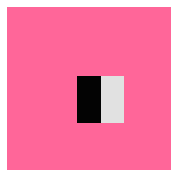

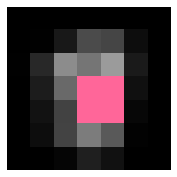

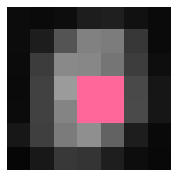

p(x ⊂ X) = 0.0
(1, 48, 2)


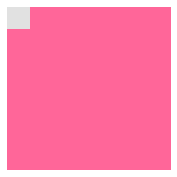

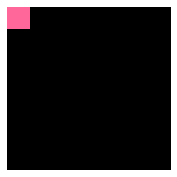

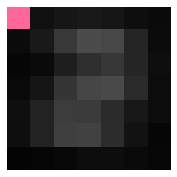

p(x ⊂ X) = 1.0
(1, 48, 2)


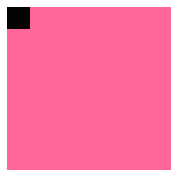

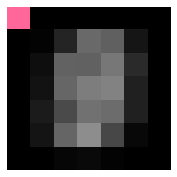

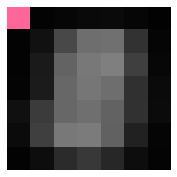

p(x ⊂ X) = 0.4118833333333333
(1, 48, 2)


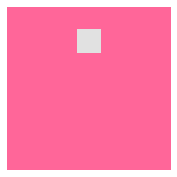

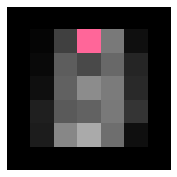

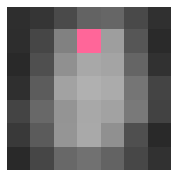

p(x ⊂ X) = 0.5881166666666666
(1, 48, 2)


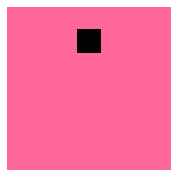

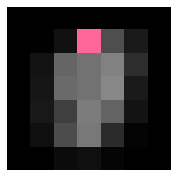

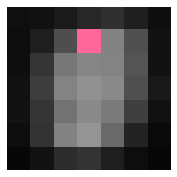

p(x ⊂ X) = 0.40286666666666665
(1, 48, 2)


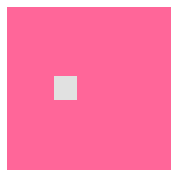

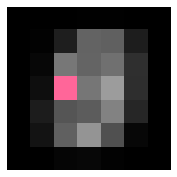

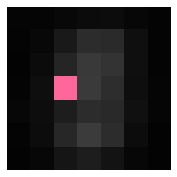

p(x ⊂ X) = 0.5971333333333333
(1, 48, 2)


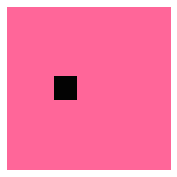

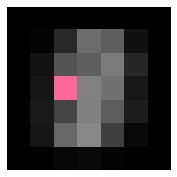

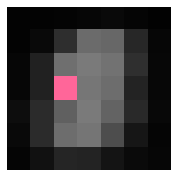

p(x ⊂ X) = 0.49105
(1, 48, 2)


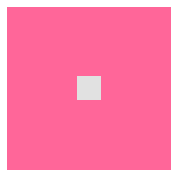

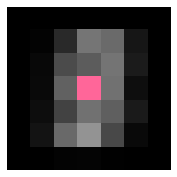

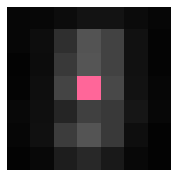

p(x ⊂ X) = 0.50895
(1, 48, 2)


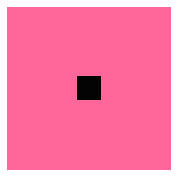

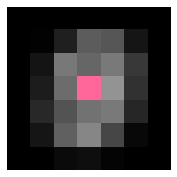

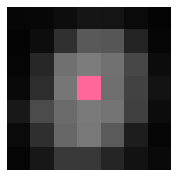

p(x ⊂ X) = 0.5117333333333334
(1, 48, 2)


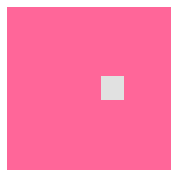

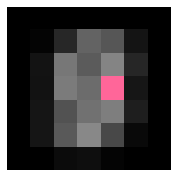

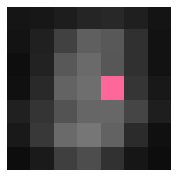

p(x ⊂ X) = 0.4882666666666667
(1, 48, 2)


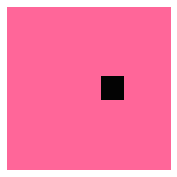

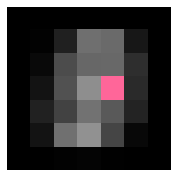

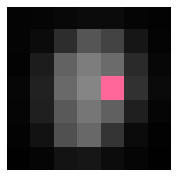

p(x ⊂ X) = 0.55335
(1, 48, 2)


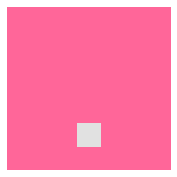

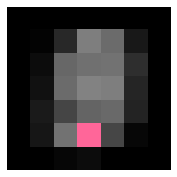

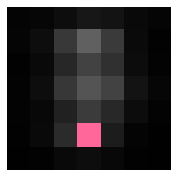

p(x ⊂ X) = 0.44665
(1, 48, 2)


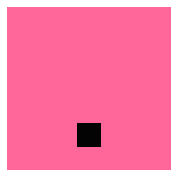

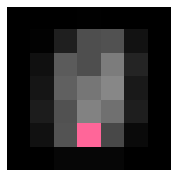

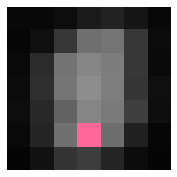

p(x ⊂ X) = 0.0791
(1, 45, 2)


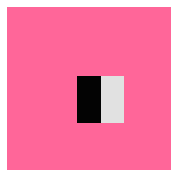

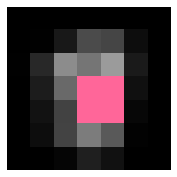

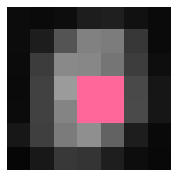

p(x ⊂ X) = 0.0
(1, 48, 2)


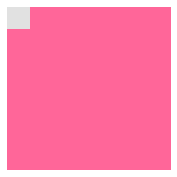

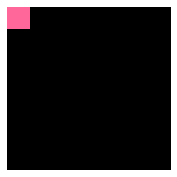

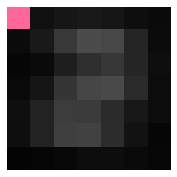

p(x ⊂ X) = 1.0
(1, 48, 2)


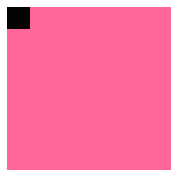

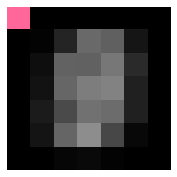

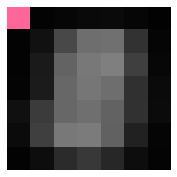

p(x ⊂ X) = 0.4118833333333333
(1, 48, 2)


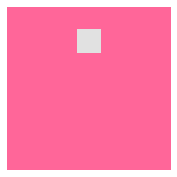

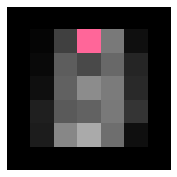

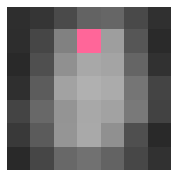

p(x ⊂ X) = 0.5881166666666666
(1, 48, 2)


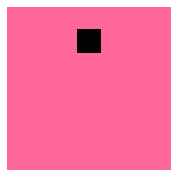

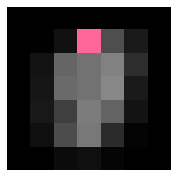

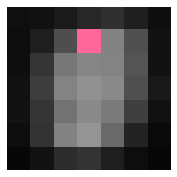

p(x ⊂ X) = 0.40286666666666665
(1, 48, 2)


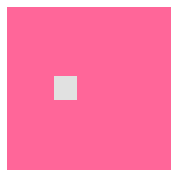

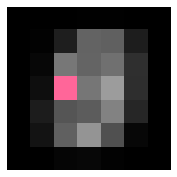

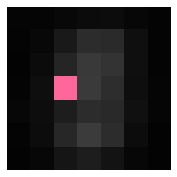

p(x ⊂ X) = 0.5971333333333333
(1, 48, 2)


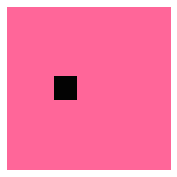

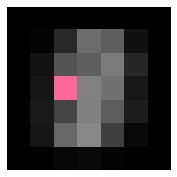

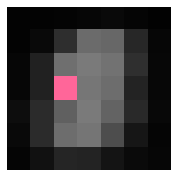

p(x ⊂ X) = 0.49105
(1, 48, 2)


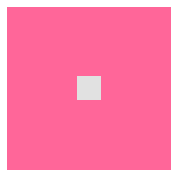

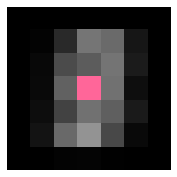

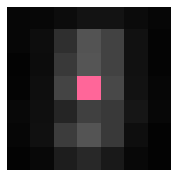

p(x ⊂ X) = 0.50895
(1, 48, 2)


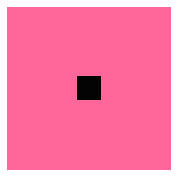

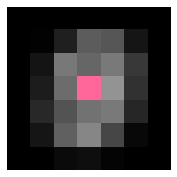

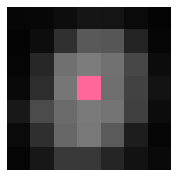

p(x ⊂ X) = 0.5117333333333334
(1, 48, 2)


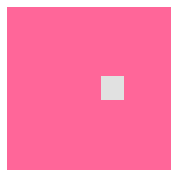

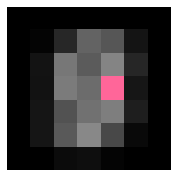

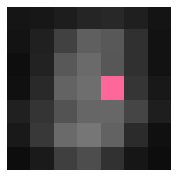

p(x ⊂ X) = 0.4882666666666667
(1, 48, 2)


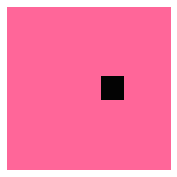

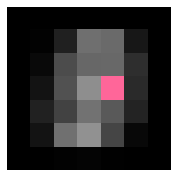

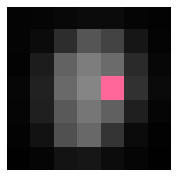

p(x ⊂ X) = 0.55335
(1, 48, 2)


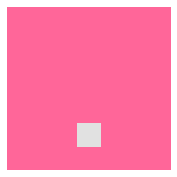

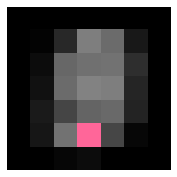

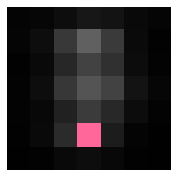

p(x ⊂ X) = 0.44665
(1, 48, 2)


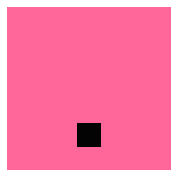

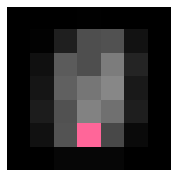

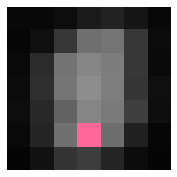

In [58]:
size = (7, 7)
h, w = size
seq_len = size[0]*size[1]

c = ((h)//2)*w + (w)//2
kvs = [
    # little square
    ([c, c+1, c+w, c+w+1], [0, 1, 0, 1]),
    
    # top left
    ([0], [1]),
    ([0], [0]),
    # down top middle
    ([1*w + (w)//2], [1]),
    ([1*w + (w)//2], [0]),
    # left of central pixel
    ([c - 1], [1]),
    ([c - 1], [0]),
    # central pixel
    ([c], [1]),
    ([c], [0]),
    # right of central pixel
    ([c + 1], [1]),
    ([c + 1], [0]),
    # near bottom middle
    ([(h-2)*w + (w)//2], [1]),
    ([(h-2)*w + (w)//2], [0]),
]

def compare_empirical_and_model_conditional_probabilities(key_vals, model):

    for ik, (ks, vs) in enumerate(key_vals):
        xk = np.ones([60000], dtype=np.bool_)
        for k, v in zip(ks, vs):
            xk = np.logical_and(xk, train[:, k] == v)
        n_xk = np.count_nonzero(xk)
        p_xk = n_xk / 60000
        print(f'p(x ⊂ X) = {p_xk}')
        i_except_k = [i for i in range(seq_len) if i not in ks]
        p_data = np.zeros([len(i_except_k), 2])
        for ii, i in enumerate(i_except_k):
            xi = train[:, i] == 1
            n_xk_and_xi = np.count_nonzero(np.logical_and(xk, xi))
            if n_xk == 0:
                n_xi_given_xk = 0
            else:
                n_xi_given_xk = float(n_xk_and_xi)/float(n_xk)
            p_data[ii, 0] = 1-n_xi_given_xk
            p_data[ii, 1] = n_xi_given_xk

        x_inp = tf.constant(vs)[None, :]
        i_inp = tf.constant(ks)[None, :]
        i_tar = tf.constant(i_except_k)[None, :]

        inp_seq_len = len(ks)
        tar_seq_len = len(i_except_k)
        enc_a_mask = models.get_mask(models.MASK_NONE, inp_seq_len, inp_seq_len)
        dec_mask = models.get_mask(models.MASK_NONE, inp_seq_len, tar_seq_len)

        logits = m([x_inp, i_inp, i_tar, enc_a_mask, dec_mask], training=False)
        print(logits.shape)
        p_model = tf.exp(logits) / (1+tf.exp(logits))

        viz.showSeq(x_inp, i_inp, size, 1, unshuffle=True, do_unquantize=True)
        viz.showSeq(p_data[np.newaxis, :, 1], i_tar, size, 1, unshuffle=True, do_unquantize=False)
        viz.showSeq(p_model[:, :, 1], i_tar, size, 1, unshuffle=True, do_unquantize=False)

m1 = keras.models.load_model('models/cuda10-mnist-7x7-bs2x1x76')
m2 = keras.models.load_model('models/cuda10-mnist-7x7-n2-bs2x1x700')
compare_empirical_and_model_conditional_probabilities(kvs, m)
compare_empirical_and_model_conditional_probabilities(kvs, m2)



In [26]:
print(tf.reduce_sum(p_data, axis=2))
print(tf.reduce_sum(p_model, axis=2))

tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]], shape=(1, 48), dtype=float64)
tf.Tensor(
[[0.9885377  0.9908053  0.9976614  1.0034558  0.9981132  0.990299
  0.9894405  0.99148226 1.0017388  1.0593045  1.097645   1.059211
  0.99065727 0.9878924  0.9898826  0.9960226  1.0666767  1.1047165
  1.077747   0.9989469  0.9883008  0.9880955  0.99049824 1.0514627
  1.0631577  1.0011554  0.98805434 0.9883647  0.99138284 1.0197179
  1.0497527  1.0307963  0.9902883  0.9863323  0.9887676  0.9960712
  1.0639025  1.094051   1.038386   0.98761654 0.98807526 0.9899804
  0.9914125  1.0081468  1.0249633  1.0107945  0.9914047  0.98902565]], shape=(1, 48), dtype=float32)
